# The Ashrae project

> Building models for the Ashrae prediction challenge.

In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
#hide
from ashrae import inspection, preprocessing, modelling
import plotly.express as px

from fastai.tabular.all import *

In [3]:
#hide
pd.options.plotting.backend = "plotly"

## Configuring

Defining wether to process the test set (warning, this alone takes 12+ minutes) and submit the results to kaggel (you will need your credentials set up).

In [10]:
do_test = False
do_submit = True

Defining where the csv files are located

In [4]:
data_path = Path("../data")

In [7]:
# !kaggle competitions download -c ashrae-energy-prediction -p {data_path}

100%|███████████████████████████████████████▉| 378M/379M [00:10<00:00, 46.2MB/s]
100%|████████████████████████████████████████| 379M/379M [00:10<00:00, 37.2MB/s]


In [9]:
# !unzip {data_path}/ashrae-energy-prediction.zip -d {data_path}/

Archive:  ../data/ashrae-energy-prediction.zip
  inflating: ../data/building_metadata.csv  
  inflating: ../data/sample_submission.csv  
  inflating: ../data/test.csv        
  inflating: ../data/train.csv       
  inflating: ../data/weather_test.csv  
  inflating: ../data/weather_train.csv  


In [10]:
# !kaggle competitions leaderboard -c ashrae-energy-prediction -p {data_path} --download

100%|███████████████████████████████████████| 70.8k/70.8k [00:00<00:00, 328kB/s]
100%|███████████████████████████████████████| 70.8k/70.8k [00:00<00:00, 328kB/s]


In [11]:
# !unzip {data_path}/ashrae-energy-prediction.zip -d {data_path}/

Archive:  ../data/ashrae-energy-prediction.zip
  inflating: ../data/ashrae-energy-prediction-publicleaderboard.csv  


## Loading

In [5]:
csvs = inspection.get_csvs(data_path)
csvs

FileNotFoundError: [Errno 2] No such file or directory: '../data'

In [12]:
%%time
train = inspection.get_core_Xy(csvs['train'])
display(train.head(), train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    uint16        
 1   meter          uint8         
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), uint16(1), uint8(1)
memory usage: 289.2 MB


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


None

CPU times: user 7.72 s, sys: 2.95 s, total: 10.7 s
Wall time: 10.7 s


In [11]:
%%time
if do_test:
    test = inspection.get_core_Xy(csvs['test'])
    display(test.head(), test.info())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


In [13]:
%%time
building = inspection.get_building_X(csvs['building'])
display(building.head(), building.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   site_id      1449 non-null   uint8   
 1   building_id  1449 non-null   uint16  
 2   primary_use  1449 non-null   category
 3   square_feet  1449 non-null   uint32  
 4   year_built   675 non-null    float32 
 5   floor_count  355 non-null    float32 
dtypes: category(1), float32(2), uint16(1), uint32(1), uint8(1)
memory usage: 23.5 KB


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


None

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 44.2 ms


In [14]:
%%time
weather_train = inspection.get_weather_X(csvs['weather_train'])
display(weather_train.head(), weather_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int64         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float64       
 3   cloud_coverage      70600 non-null   float64       
 4   dew_temperature     139660 non-null  float64       
 5   precip_depth_1_hr   89484 non-null   float64       
 6   sea_level_pressure  129155 non-null  float64       
 7   wind_direction      133505 non-null  float64       
 8   wind_speed          139469 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


None

CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 105 ms


In [15]:
%%time
if do_test:
    weather_test = inspection.get_weather_X(csvs['weather_test'])
    display(weather_test.head(), weather_test.info())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


## Building features

In [16]:
process_config = dict(
    add_time_features = True,
    add_dep_var_stats = True,
    df_building = building,
    df_weather = weather_train
)
process = preprocessing.Processor()

In [17]:
%%time
df, var_names = process(train.copy(), 
                        **process_config)

CPU times: user 23.5 s, sys: 33.7 s, total: 57.1 s
Wall time: 56 s


In [18]:
%%time
if do_test:
    df_test, _ = process(test.copy(), 
                         **process_config)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs


## Sampling from `df`

In [19]:
%%time
n = len(df)

if True: # per building_id and meter sampling
    n_sample_per_bid = 500
    replace = True

    df = (df.groupby(['building_id', 'meter'])
         .sample(n=n_sample_per_bid, replace=replace))

if False: # general sampling
    frac_samples = .05
    replace = False

    df = (df.sample(frac=frac_samples, replace=replace))

print(f'using {len(df)} samples = {len(df)/n*100:.2f} %')

using 1190000 samples = 5.89 %
CPU times: user 17.9 s, sys: 2.84 s, total: 20.7 s
Wall time: 20.8 s


## Preparing the data for modelling

In [20]:
%%time
split_kind = 'random'
#split_kind = 'time'
splits = modelling.split_dataset(df, split_kind=split_kind, train_frac=.8)
#splits=None

CPU times: user 359 ms, sys: 0 ns, total: 359 ms
Wall time: 377 ms


In [21]:
%%time
to = preprocessing.get_tabular_object(df, var_names, splits=splits)

CPU times: user 8.83 s, sys: 875 ms, total: 9.7 s
Wall time: 9.76 s


In [22]:
%%time
train_bs = 256*8
val_bs = 256*8

dls = to.dataloaders(bs=train_bs, val_bs=val_bs)

CPU times: user 78.1 ms, sys: 93.8 ms, total: 172 ms
Wall time: 217 ms


In [23]:
%%time
test_bs = 1024*4

if do_test:
    test_dl = dls.test_dl(df_test, bs=test_bs) 

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.77 µs


## Training a neural net using `tabular_learner`

In [24]:
y_range = [0,
           np.max([to.train.ys.values.max(), 
                   to.valid.ys.values.max()]),]
y_range

[0, 16.900833]

In [29]:
layers = [50, 25, 12]

config = tabular_config(embed_p=.1, ps = [.1, .1, .1])

learn = tabular_learner(dls, y_range=y_range, layers=layers,
                        n_out=1, config=config, 
                        loss_func=modelling.evaluate_torch)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.009120108559727669)

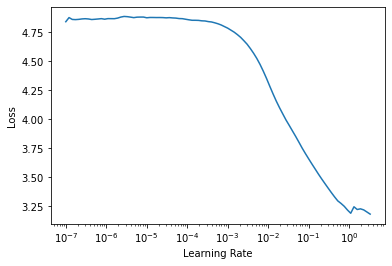

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(5, lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,1.174356,3.134203,01:35
1,1.053987,7.457788,02:16
2,0.996315,4.860970,02:24
3,0.959582,3.924056,02:23
4,0.946013,3.892275,02:22


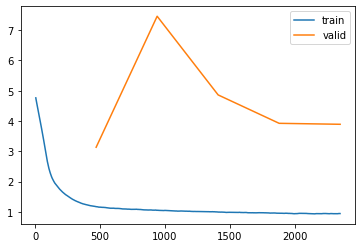

In [32]:
learn.recorder.plot_loss()

## Inspecting the predictions

### Basic score

In [33]:
%%time
y_valid_pred, y_valid_true = learn.get_preds()

CPU times: user 8.25 s, sys: 2.97 s, total: 11.2 s
Wall time: 5.16 s


In [34]:
%%time
if do_test:
    y_test_pred, _ = learn.get_preds(dl=test_dl)
    y_test_pred = cnr(y_test_pred)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.6 µs


In [36]:
nb_score = modelling.evaluate_torch(y_valid_true, 
                                    y_valid_pred).item()
print(f'fastai loss {nb_score:.4f}')

fastai loss 3.9323


In [38]:
y_valid_pred, y_valid_true = modelling.cnr(y_valid_pred), modelling.cnr(y_valid_true)

### Histogram of  `dep_var`

In [ ]:
preprocessing.hist_plot_preds(modelling.pick_random(y_valid_true), 
                              modelling.pick_random(y_valid_pred), 
                              label0='truth', label1='prediction')

In [ ]:
if do_test:
    preprocessing.hist_plot_preds(modelling.pick_random(y_valid_true), 
                                  modelling.pick_random(y_test_pred), 
                                  label0='truth (validation)', 
                                  label1='prediction (test set)').show()

### Confidently wrong predictions by `building_id`

In [41]:
%%time
bwt = preprocessing.BoldlyWrongTimeseries(to.valid.xs, y_valid_true, y_valid_pred,
                                          t=df.iloc[splits[1]].loc[:,['timestampElapsed']].copy())

CPU times: user 1.55 s, sys: 344 ms, total: 1.89 s
Wall time: 1.93 s


In [ ]:
bwt.run_boldly()

## Submission

In [ ]:
%%time
if do_test:
    y_test_pred_original = torch.exp(tensor(y_test_pred)) - 1

    y_out = pd.DataFrame(cnr(y_test_pred_original),
                         columns=['meter_reading'],
                         index=df_test.index)
    display(y_out.head())

    assert len(y_out) == 41697600

In [ ]:
%%time
if do_submit:
    y_out.to_csv(data_path/'my_submission.csv')

In [ ]:
# message = ['random forest', '500 obs/bid', 'all features', f'nb score {nb_score:.4f}']
message = ['lightgbm', '500 obs/bid', '100 rounds', '42 leaves', 'lr .5', f'nb score {nb_score:.4f}']
# message = ['tabular_learner', '500 obs/bid', 'all features', f'layers {layers}, embed_p .1, ps [.1,.1,.1]', f'nb score {nb_score:.4f}']
message = ' + '.join(message)
message

In [ ]:
if do_test and do_submit:
    print('Submitting...')
    !kaggle competitions submit -c ashrae-energy-prediction -f '{data_path}/my_submission.csv' -m '{message}'